In [2]:
!pip install tensorflow

In [1]:
from numpy import asarray
import numpy as np

import os
import cv2
import glob
import imagehash
# !pip install imagehash
from PIL import Image

import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout
from keras import optimizers
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from pickle import dump

import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:

images = sorted(glob.glob("Water_Bodies_Dataset/Images/*.jpg"))
masks = sorted(glob.glob("Water_Bodies_Dataset/Masks/*.jpg"))

print(len(images), len(masks))

2841 2841


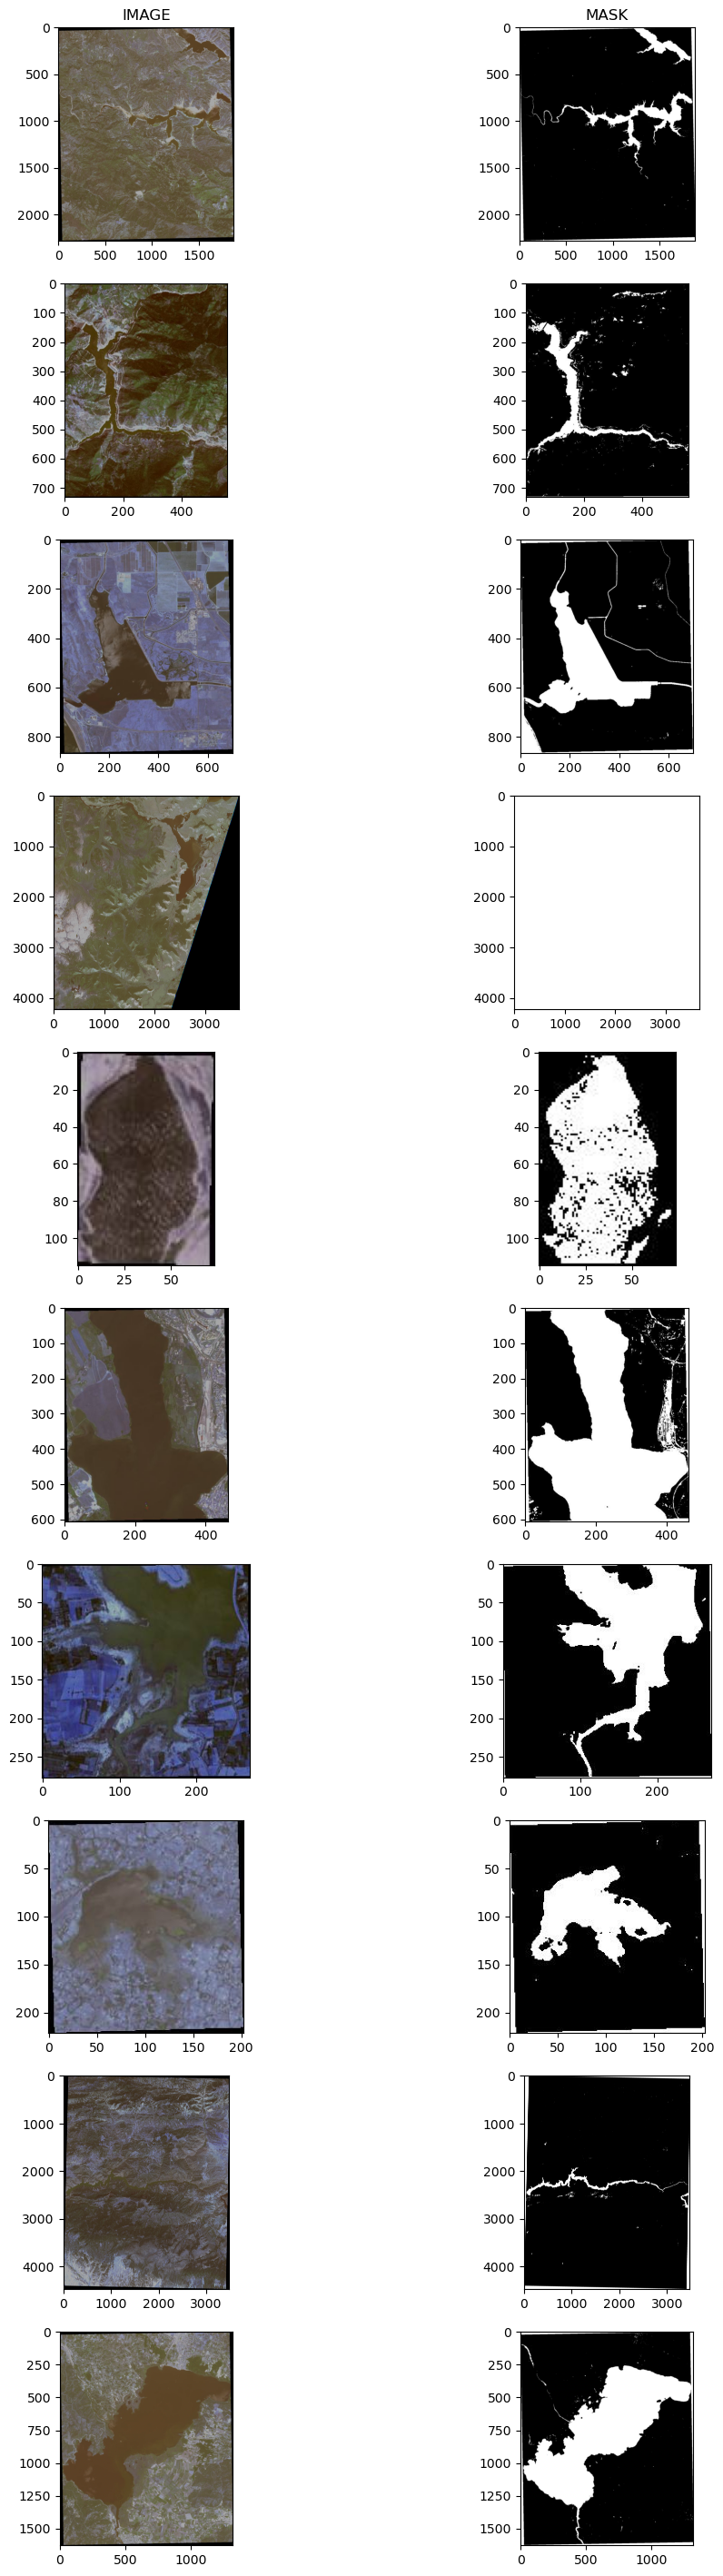

In [3]:
f, axr = plt.subplots(10,2, figsize=(12,36))
for i in range(10):
    idx = np.random.randint(0, len(images))
    original = cv2.imread(images[idx])
    mask = cv2.imread(masks[idx])
    axr[i,0].imshow(original)
    axr[i,1].imshow(mask)
    i +=1
    axr[0, 0].set_title("IMAGE")
    axr[0, 1].set_title("MASK")

In [4]:
# Calculate statistics of the image dimensions
dimen_img_list = []

for img in images:
    img = cv2.imread(img, cv2.COLOR_BGR2RGB)
    dimen_img = img.shape[:2]
    dimen_img_list.append(dimen_img)

# Convert the list to numpy array
dimen_img_array = np.array(dimen_img_list)

In [5]:
print("Statistics of image dimensions:")
print("Minimum width:", np.min(dimen_img_array[:, 1]))
print("Maximum width:", np.max(dimen_img_array[:, 1]))
print("Mean width:", np.mean(dimen_img_array[:, 1]))
print("Median width:", np.median(dimen_img_array[:, 1]))
print("Standard deviation of width:", np.std(dimen_img_array[:, 1]))
print("Minimum height:", np.min(dimen_img_array[:, 0]))
print("Maximum height:", np.max(dimen_img_array[:, 0]))
print("Mean height:", np.mean(dimen_img_array[:, 0]))
print("Median height:", np.median(dimen_img_array[:, 0]))
print("Standard deviation of height:", np.std(dimen_img_array[:, 0]))

Statistics of image dimensions:
Minimum width: 5
Maximum width: 5640
Mean width: 445.2555438225977
Median width: 259.0
Standard deviation of width: 553.6202774845702
Minimum height: 7
Maximum height: 7093
Mean height: 560.6652587117212
Median height: 334.0
Standard deviation of height: 688.890393959364


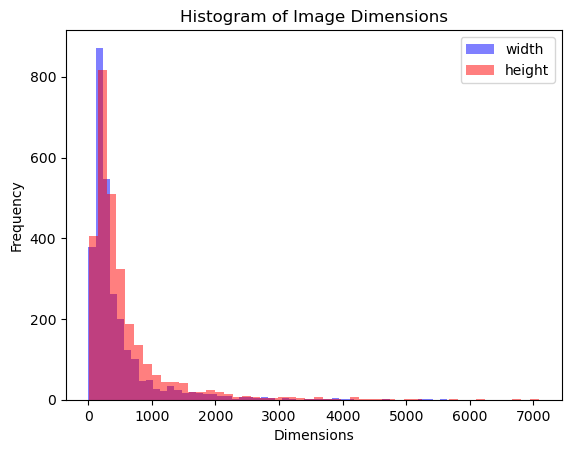

In [6]:
plt.hist(dimen_img_array[:, 1], bins=50, alpha=0.5, color='blue', label='width')
plt.hist(dimen_img_array[:, 0], bins=50, alpha=0.5, color='red', label='height')
plt.xlabel('Dimensions')
plt.ylabel('Frequency')
plt.title('Histogram of Image Dimensions')
plt.legend()
plt.show()

In [7]:
#Detect and remove duplicate images and masks
hashes = {}
to_remove = []

for file in images:
    if file.endswith('.jpg'):
        with open(file, 'rb') as f:
            img = Image.open(f)
            # Compute the hash value for the image
            h = imagehash.phash(img)
            # Check if the hash value already exists in the dictionary
            if h in hashes:
                print(f'Duplicate image found: {file} and {hashes[h]}')
                to_remove.append(file)
                mask_file = os.path.join("Water_Bodies_Dataset/Masks", os.path.basename(file))
                to_remove.append(mask_file)
            else:
                hashes[h] = file

Duplicate image found: Water_Bodies_Dataset/Images\water_body_1244.jpg and Water_Bodies_Dataset/Images\water_body_1023.jpg
Duplicate image found: Water_Bodies_Dataset/Images\water_body_1333.jpg and Water_Bodies_Dataset/Images\water_body_1023.jpg
Duplicate image found: Water_Bodies_Dataset/Images\water_body_1552.jpg and Water_Bodies_Dataset/Images\water_body_1023.jpg
Duplicate image found: Water_Bodies_Dataset/Images\water_body_1619.jpg and Water_Bodies_Dataset/Images\water_body_1023.jpg
Duplicate image found: Water_Bodies_Dataset/Images\water_body_1659.jpg and Water_Bodies_Dataset/Images\water_body_1023.jpg
Duplicate image found: Water_Bodies_Dataset/Images\water_body_2312.jpg and Water_Bodies_Dataset/Images\water_body_1023.jpg
Duplicate image found: Water_Bodies_Dataset/Images\water_body_608.jpg and Water_Bodies_Dataset/Images\water_body_1023.jpg
Duplicate image found: Water_Bodies_Dataset/Images\water_body_636.jpg and Water_Bodies_Dataset/Images\water_body_1023.jpg
Duplicate image fo

In [8]:
# Create a new list of filenames that excludes the duplicates
new_images = [file for file in images if file not in to_remove]
new_masks = [os.path.join("Water_Bodies_Dataset/Masks", os.path.basename(file)) for file in new_images]
print(len(new_images), len(new_masks))

2824 2824


In [9]:

min_size = 32
df_images = []
df_masks = []

height = width = 300

for image, mask in zip(new_images, new_masks):
    #cv2.imread reads image in BGR, we need to convert it back to the standard mode RGB
    n = cv2.imread(image, cv2.COLOR_BGR2RGB)
    m = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)

    # Check if the image has size > min_size and is entirely black or white
    if min(n.shape[:2]) > min_size and ((m != 0).any() and (m != 255).any()):
        n = cv2.resize(n, (height, width)) # resize to median values or larger
        df_images.append(n)
        m = cv2.resize(m, (height, width)) # resize to median values or larger
        df_masks.append(m)

# Convert image into array of pixels
df_images = asarray(df_images)

# Convert mask into array of pixels
df_masks = asarray(df_masks)

print(len(df_images), len(df_masks))

2698 2698


In [10]:

X = df_images
y = df_masks

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.015, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(2023, 300, 300, 3) (2023, 300, 300) (664, 300, 300, 3) (664, 300, 300) (11, 300, 300, 3) (11, 300, 300)


In [11]:
X_train = X_train.reshape(X_train.shape[0], height, width, 3).astype('float32')
X_test = X_test.reshape(X_test.shape[0], height, width, 3).astype('float32')
X_val = X_val.reshape(X_val.shape[0], height, width, 3).astype('float32')
y_train = y_train.reshape(y_train.shape[0], height, width).astype('float32')
y_test = y_test.reshape(y_test.shape[0], height, width).astype('float32')
y_val = y_val.reshape(y_val.shape[0], height, width).astype('float32')

In [12]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255
y_train = y_train / 255
y_test = y_test / 255
y_val = y_val / 255

In [13]:
print(X_train.shape, X_test.shape)

(2023, 300, 300, 3) (664, 300, 300, 3)


In [14]:
input_shape = (height, width, 3)

def base_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoding layers
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoding layers
    up3 = layers.UpSampling2D(size=(2, 2))(pool2)
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
    conv4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    outputs = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(up5)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Build the model
model = base_model(input_shape)

# Reshape target data to match output shape of the model
y_train = y_train.reshape(-1, height, width, 1)
y_test = y_test.reshape(-1, height, width, 1)

In [15]:
# Define a callback for early stopping if the validation loss does not improve for 10 consecutive 
# epochs (patience=10).
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [16]:
# Fit the model to train and test sets
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/20


32/32 [==============================] - 264s 7s/step - loss: 0.5399 - accuracy: 0.6140 - val_loss: 0.4784 - val_accuracy: 0.6655
Epoch 2/20
32/32 [==============================] - 248s 8s/step - loss: 0.4709 - accuracy: 0.6569 - val_loss: 0.4507 - val_accuracy: 0.6686
Epoch 3/20
32/32 [==============================] - 216s 7s/step - loss: 0.4567 - accuracy: 0.6587 - val_loss: 0.4401 - val_accuracy: 0.6658
Epoch 4/20
32/32 [==============================] - 216s 7s/step - loss: 0.4400 - accuracy: 0.6695 - val_loss: 0.4214 - val_accuracy: 0.6748
Epoch 5/20
32/32 [==============================] - 216s 7s/step - loss: 0.4139 - accuracy: 0.6858 - val_loss: 0.4052 - val_accuracy: 0.6889
Epoch 6/20
32/32 [==============================] - 217s 7s/step - loss: 0.3980 - accuracy: 0.6934 - val_loss: 0.4189 - val_accuracy: 0.6732
Epoch 7/20
32/32 [==============================] - 218s 7s/step - loss: 0.4041 - accuracy: 0.6909 - val_loss: 0.3714 - val_accuracy: 0.7064
Epoch 8/20


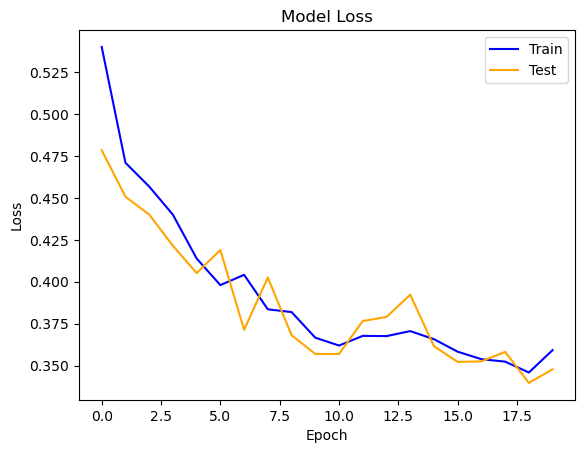

In [17]:
plt.title('Model Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc ="upper right")

In [18]:
gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

In [19]:
train_gen = gen.flow(X_train, y_train, batch_size=64)
test_gen = gen.flow(X_test, y_test, batch_size=64)

In [20]:
model2 = base_model(input_shape)

In [21]:
history2 = model2.fit(train_gen, epochs=20, batch_size=64, validation_data=test_gen, callbacks=[early_stopping])

Epoch 1/20
32/32 [==============================] - 523s 17s/step - loss: 0.5910 - accuracy: 0.5914 - val_loss: 0.5493 - val_accuracy: 0.5884
Epoch 2/20
32/32 [==============================] - 249s 8s/step - loss: 0.5494 - accuracy: 0.6040 - val_loss: 0.5434 - val_accuracy: 0.6199
Epoch 3/20
32/32 [==============================] - 244s 8s/step - loss: 0.5535 - accuracy: 0.6115 - val_loss: 0.5583 - val_accuracy: 0.6200
Epoch 4/20
32/32 [==============================] - 246s 8s/step - loss: 0.5485 - accuracy: 0.6155 - val_loss: 0.5380 - val_accuracy: 0.6294
Epoch 5/20
32/32 [==============================] - 247s 8s/step - loss: 0.5421 - accuracy: 0.6177 - val_loss: 0.5416 - val_accuracy: 0.6258
Epoch 6/20
32/32 [==============================] - 246s 8s/step - loss: 0.5369 - accuracy: 0.6245 - val_loss: 0.5277 - val_accuracy: 0.6366
Epoch 7/20
32/32 [==============================] - 297s 9s/step - loss: 0.5337 - accuracy: 0.6290 - val_loss: 0.5258 - val_accuracy: 0.6326
Epoch 8/20
3

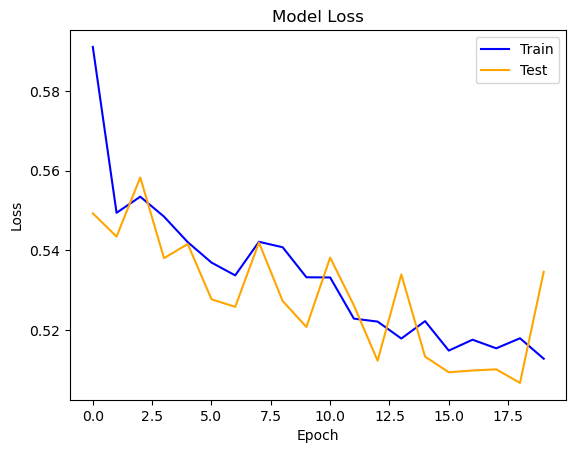

In [22]:
plt.title('Model Loss')
plt.plot(history2.history['loss'], color='blue', label='train')
plt.plot(history2.history['val_loss'], color='orange', label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc ="upper right")

1/1 [==============================] - 1s 866ms/step


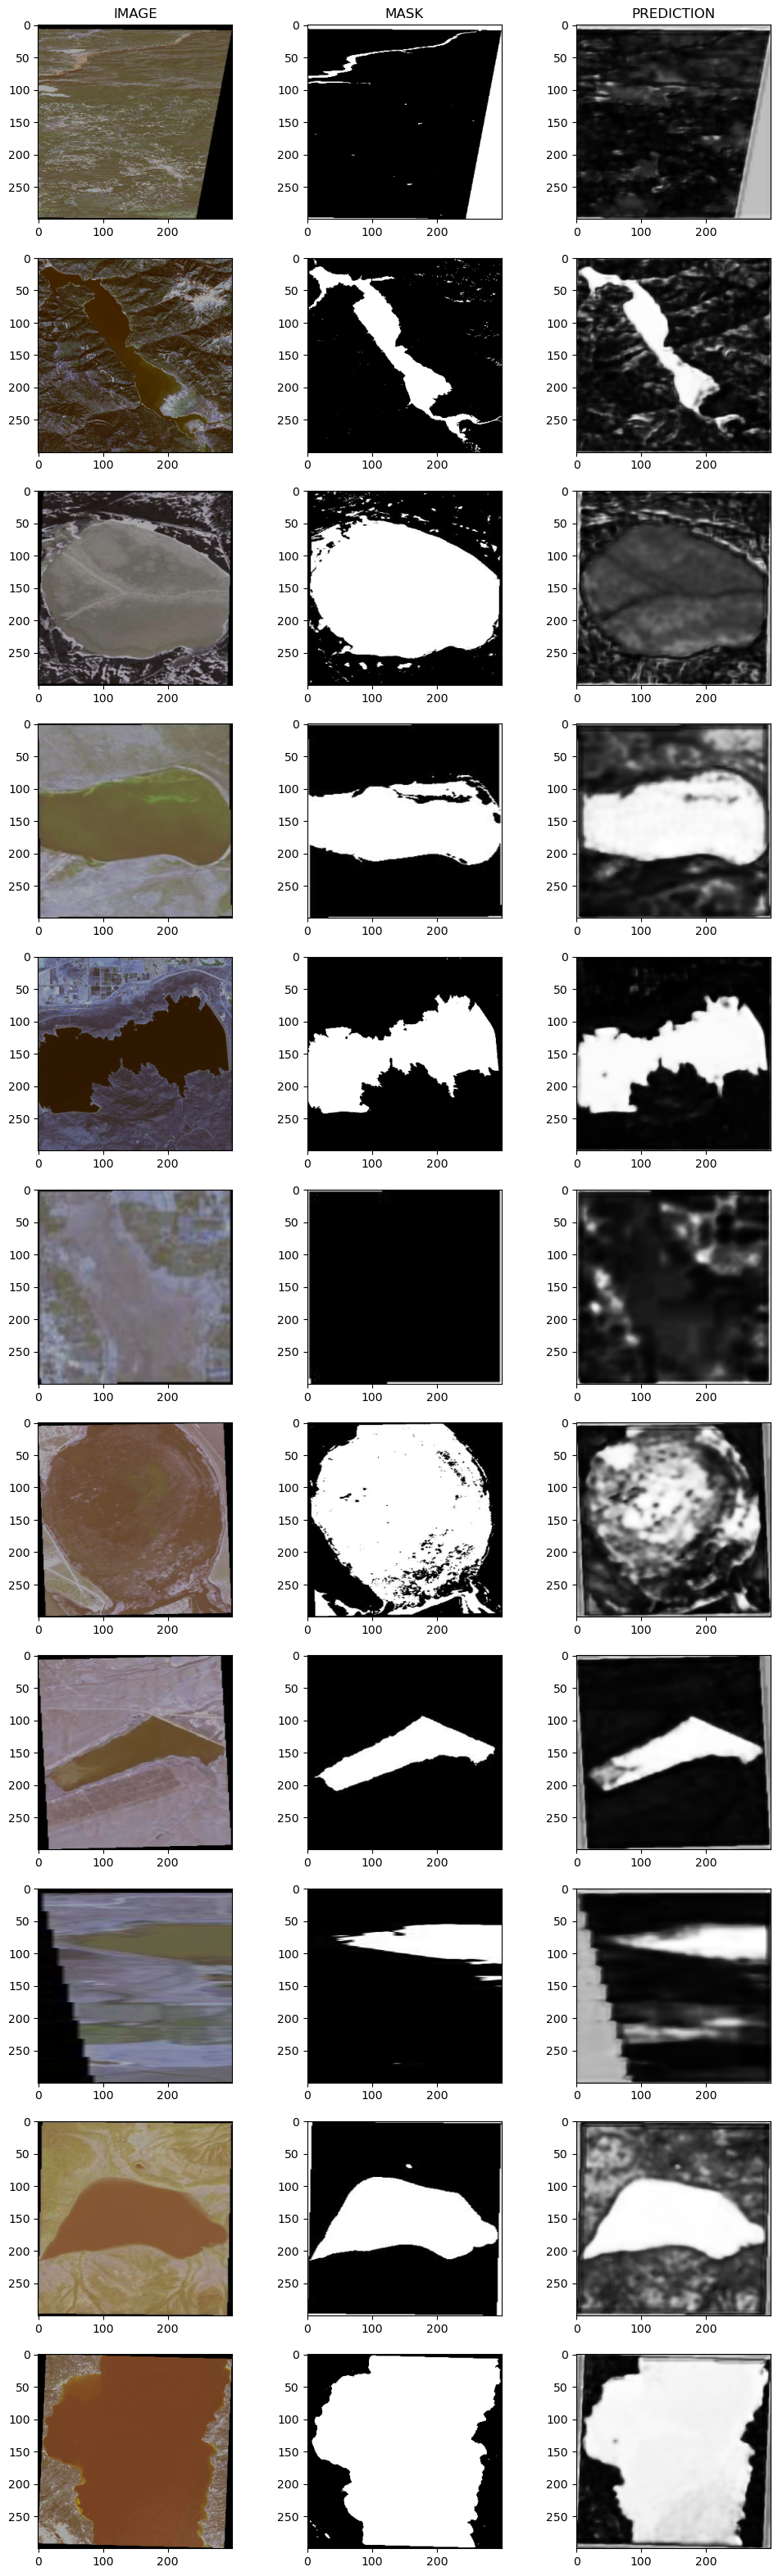

In [23]:
# a) Predictions on validation data
Pred = model.predict(X_val)

# Plot original and predicted images
fig, ax = plt.subplots(11, 3, figsize=(12,40))
for i in range(11):
    orig = X_val[i]
    msk = y_val[i]
    pred = Pred[i]
    ax[i,0].imshow(orig)
    ax[i,1].imshow(msk, cmap='gray')
    ax[i,2].imshow(pred, cmap='gray')
    i +=1
    ax[0, 0].set_title("IMAGE")
    ax[0, 1].set_title("MASK")
    ax[0, 2].set_title("PREDICTION")

In [27]:
# b) Save the model for later use

# save the model to disk
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))